In [1]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go

In [29]:
# three vehicles

#alpha: TQQQ, TECL
#beta: XLU
#omega: SPY, QQQ

### read data

In [106]:
alpha = pd.read_csv("data/TQQQ_daily.csv")
omega = pd.read_csv("data/QQQ_daily.csv")

### engineer features

In [157]:
#performance features
alpha['high_adj'] = (alpha['High'] - alpha['Close']) / alpha['Close']
alpha['low_adj'] = (alpha['Low'] - alpha['Close']) / alpha['Close']
alpha['body'] = (alpha['Close'] - alpha['Open']) / alpha['Open']

#return features
alpha['close_prev'] = alpha['Close'].shift(1)
alpha['close_next'] = alpha['Close'].shift(-1)

alpha['close_prev_week'] = alpha['Close'].shift(7)
alpha['close_next_week'] = alpha['Close'].shift(-7)

alpha['change'] = (alpha['Close'] - alpha['close_prev']) / alpha['close_prev']
alpha['change_next'] = (alpha['Close'] - alpha['close_next']) / alpha['Close']
alpha['change_next_week'] = (alpha['Close'] - alpha['close_next_week']) / alpha['Close']

#MA features
alpha['ma_7'] = alpha['Close'].rolling(window=7).mean()
alpha['ma_3'] = alpha['Close'].rolling(window=3).mean()
alpha['ma_200'] = alpha['Close'].rolling(window=200).mean()

#macro trend (above longer term MA)
alpha['macro_uptrend'] = alpha['ma_200'] < alpha['Close']
alpha['macro_uptrend'] = alpha['macro_uptrend'].apply(lambda x: 1 if x else 0)
alpha['pct_above_ma_200'] = (alpha['Close'] - alpha['ma_200']) / stocks['Close']

#micro trend (above shorter term MA)
alpha['pct_above_ma_7'] = (alpha['Close'] - alpha['ma_7']) / alpha['Close']
alpha['pct_above_ma_3'] = (alpha['Close'] - alpha['ma_3']) / alpha['Close']

#normalized MA slopes
alpha['ma_7_prev'] = alpha['ma_7'].shift(1) 
alpha['ma_7_change'] = (alpha['ma_7'] - alpha['ma_7_prev']) / alpha['ma_7_prev']


#feature wishlist
# - MA slope
# - drawdown in next 3 days
# - volume % above n day average
# - consecutive days above MA

#label wishlist
# - 3 day return

#questions
#are returns better on 1st or 2nd day of closes above MA

alpha = alpha.iloc[200:]

In [158]:
alpha[['Date', 'Open', 'Close', 'close_next', 'close_next', 'ma_7_prev', 'ma_7', 'ma_7_change']].head()

,Date,Open,Close,close_next,close_next,ma_7_prev,ma_7,ma_7_change
1600,2016-06-21,16.131666,16.193333,16.088333,16.088333,16.244524,16.163571,-0.004983
1601,2016-06-22,16.240000,16.088333,16.766666,16.766666,16.163571,16.129047,-0.002136
1602,2016-06-23,16.461666,16.766666,14.713333,14.713333,16.129047,16.190238,0.003794
1603,2016-06-24,15.000000,14.713333,13.856667,13.856667,16.190238,15.979047,-0.013044
1604,2016-06-27,14.378333,13.856667,14.725000,14.725000,15.979047,15.628809,-0.021919


### define and execute trade functions

In [110]:
long = False

def take_action(s, ma):
    global long
    if s['Close'] < s['ma_' + ma]:
        if long: 
            long = False
            return -1
        else: return 0
    if s['Close'] >= s['ma_' + ma]:
        if long: return 0
        else: 
            long = True
            return 1

alpha['action_ma_7'] = alpha.apply(take_action, axis=1, args=('7',))
alpha['action_ma_3'] = alpha.apply(take_action, axis=1, args=('3',))


In [37]:
sample = alpha.iloc[10:100]
data = [go.Candlestick(
                x=sample['Date'],
                open=sample['Open'],
                high=sample['High'],
                low=sample['Low'],
                close=sample['Close'],
                name='price'),
                go.Scatter(x=sample['Date'],
                y=sample['ma_7'],
                mode="lines",
                line={'color': 'cyan'},
                name='MA 7')]
annotations = []
fig = go.Figure(data=data)


#fig.show()

In [145]:
alpha[['Date', 'Close', 'ma_7', 'action_ma_7']].head(3)

,Date,Close,ma_7,action_ma_7
800,2013-04-18,4.661667,5.080714,0
801,2013-04-19,4.855000,5.016548,0
802,2013-04-22,5.004167,4.975000,1


### feature binning

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a26b4c550>,
      dtype=object)

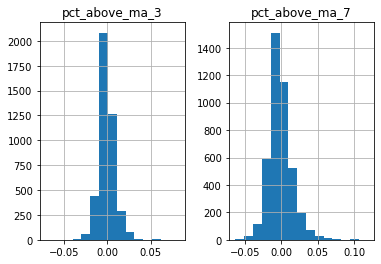

In [113]:
stocks[['pct_above_ma_7', 'pct_above_ma_3']].hist(bins=15)

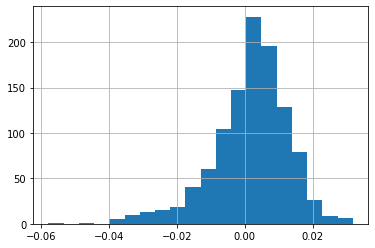

In [156]:
alpha['ma_7_slope'].hist(bins=20)

### conditional probability exloration

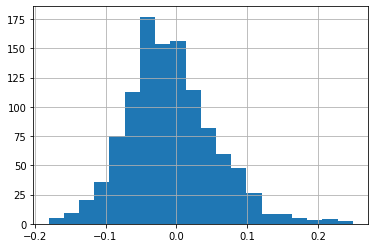

In [129]:
alpha[(alpha['macro_uptrend'] == 1) & (alpha['Close'] > alpha['ma_7'])]['change_next'].hist(bins=20)

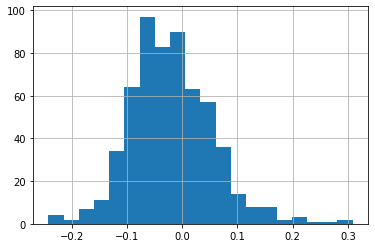

In [130]:
alpha[(alpha['macro_uptrend'] == 1) & (alpha['Close'] < alpha['ma_7'])]['change_next'].hist(bins=20)

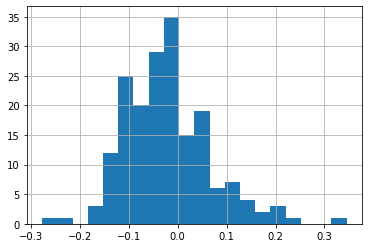

In [131]:
alpha[(alpha['macro_uptrend'] == 0) & (alpha['Close'] > alpha['ma_7'])]['change_next'].hist(bins=20)

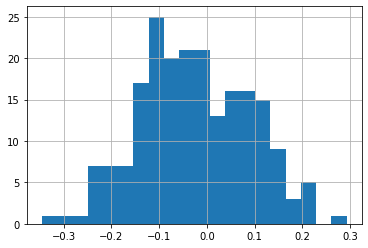

In [132]:
alpha[(alpha['macro_uptrend'] == 0) & (alpha['Close'] < alpha['ma_7'])]['change_next'].hist(bins=20)

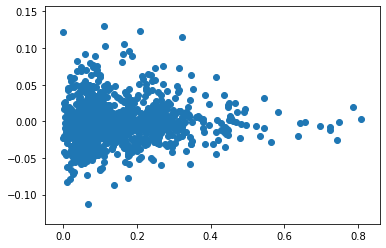

In [148]:
macro = alpha[alpha['macro_uptrend'] == 1]
plt.scatter(macro['pct_above_ma_200'], macro['change_next'])

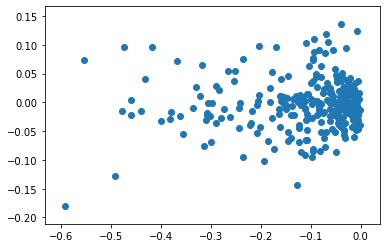

In [147]:
macro = alpha[alpha['macro_uptrend'] == 0]
plt.scatter(macro['pct_above_ma_200'], macro['change_next'])

In [ ]:
plt.scatter(alpha['']) 